# Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
import cv2 as cv
# import time

# Parameters

In [2]:
cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211207/mouse_01_CA1'
dict_meta = {'framerate_inscopix': 10,
             'framerate_behavior': 15,
             'frame_count': np.array([2130,1853,1841,1851,1828,1956,1857,1838,1843,1850,1863,1847]),
             'discard_sessions': np.array([0,2]),
             'dict_env': {'t_maze': [0,2,6,8],
                          'y_maze': [3,5,9],
                          'open_field': [1,4,7]}
            }

# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211206/mouse_01_CA1'
# dict_meta = {'framerate_inscopix': 10,
#              'framerate_behavior': 15,
#              'frame_count': np.array([1969,2090,1847,1841,1836,1842,1846,1847,1838,1989,1903,1863]),
#              'discard_sessions': np.array([11]),
#              'dict_env': {'t_maze': [0,4,6,10],
#                           'y_maze': [1,3,7,9],
#                           'open_field': [2,5,8]}
#             }

# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211206/mouse_02_IL'
# dict_meta = {'framerate_inscopix': 20,
#              'framerate_behavior': 15,
#              'frame_count': np.array([3641,3773,3800,3691,3867,4254,3945,3793,3946,3647,3721,3682]),
#              'discard_sessions': np.array([8]),
#              'dict_env': {'t_maze': [0,4,6,9],
#                           'y_maze': [1,3,7,8],
#                           'open_field': [2,5,10]}
#             }

# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_01_CA1'
# dict_meta = {'framerate_inscopix': 10,
#              'framerate_behavior': 15,
#              'frame_count': np.array([2102,2054,1896,2011,1948,1859,1852,1838,1870,1945,1891,1897]),
#              'discard_sessions': np.array([]),
#              'dict_env': {'t_maze': [1,3,7,9],
#                           'y_maze': [0,4,6,10],
#                           'open_field': [2,5,8,11]}
#             }

# cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_02_IL'
# dict_meta = {'framerate_inscopix': 20,
#              'framerate_behavior': 15,
#              'frame_count': np.array([4015, 3709, 3872, 3715, 3737, 3752, 4344, 3698, 4628, 3801, 3770, 3774]),
#              'discard_sessions': np.array([8,9]),
#              'dict_env': {'t_maze': [0, 3, 6],
#                           'y_maze': [1, 4, 7, 8],
#                           'open_field': [2, 5, 9]}
#             }

path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')

# Loading files

## Table frames

In [3]:
df_frames = pd.read_csv(path_table, index_col = 0)
df_frames['session'] = ''
for i,r in df_frames.iterrows():
    df_frames.loc[i, 'session'] = df_frames.loc[i, 'file'].split('.')[0]

## Matrix spikes

### Loading

In [4]:
with h5py.File(path_mat_spikes, 'r') as f:
    mat_spikes = csr_matrix((f['finalSpikesMat']['data'], f['finalSpikesMat']['ir'], f['finalSpikesMat']['jc']))
    mat_spikes = mat_spikes.toarray()
    
n_frames_theoretical = np.sum(dict_meta['frame_count'])
n_frames_real = mat_spikes.shape[0]
print('Theoretical number of frames: %d\nReal number of frames: %d' % (n_frames_theoretical, n_frames_real))

Theoretical number of frames: 22557
Real number of frames: 22557


### Plotting first neurons for sanity check

(22557, 547)


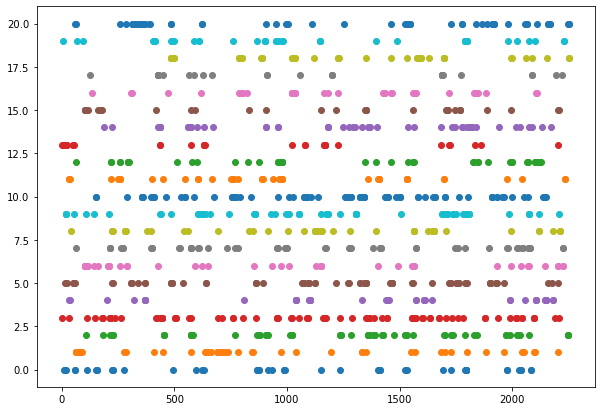

In [5]:
plt.figure(figsize = (10,7))
for (i,r) in enumerate(mat_spikes.T):
    if i > 20:
        break
    spikes = np.where(r)[0]
    plt.scatter(spikes/dict_meta['framerate_inscopix'], [i] * len(spikes))
print(mat_spikes.shape)

### Getting recording ratios

In [6]:
meta_spikes = pd.DataFrame(index = range(mat_spikes.shape[0]), columns = ['session', 'frame_number', 'frame_ratio'])

cursor = 0
cur_session = -1
for i, fcount in enumerate(dict_meta['frame_count']):
    
    end_cursor = cursor + fcount - 1
    if i in dict_meta['discard_sessions']:
        session_label = 'discarded' 
    else:
        cur_session += 1
        session_label = df_frames.loc[cur_session, 'file'].split('.')[0]
        
    meta_spikes.loc[cursor:end_cursor, 'session'] = session_label
    meta_spikes.loc[cursor:end_cursor, 'frame_number'] = range(fcount)
    meta_spikes.loc[cursor:end_cursor, 'recording_ratio'] = meta_spikes.loc[cursor:end_cursor, 'frame_number'] / (fcount - 1)
    cursor += fcount

from collections import Counter
print(Counter(meta_spikes['session']))
meta_spikes

Counter({'discarded': 3971, 'WIN_20211207_11_26_28_Pro': 1956, 'WIN_20211207_11_46_09_Pro': 1863, 'WIN_20211207_11_30_38_Pro': 1857, 'WIN_20211207_11_11_55_Pro': 1853, 'WIN_20211207_11_19_12_Pro': 1851, 'WIN_20211207_11_41_54_Pro': 1850, 'WIN_20211207_11_50_09_Pro': 1847, 'WIN_20211207_11_38_01_Pro': 1843, 'WIN_20211207_11_34_17_Pro': 1838, 'WIN_20211207_11_22_50_Pro': 1828})


,session,frame_number,frame_ratio,recording_ratio
0,discarded,0,NaN,0.0
1,discarded,1,NaN,0.00047
2,discarded,2,NaN,0.000939
3,discarded,3,NaN,0.001409
4,discarded,4,NaN,0.001879
...,...,...,...,...
22552,WIN_20211207_11_50_09_Pro,1842,NaN,0.997833
22553,WIN_20211207_11_50_09_Pro,1843,NaN,0.998375
22554,WIN_20211207_11_50_09_Pro,1844,NaN,0.998917
22555,WIN_20211207_11_50_09_Pro,1845,NaN,0.999458


## Deep lab cut

### Loading

In [7]:
dlc_files = np.array(os.listdir(os.path.join(cur_dir, 'dlc')))
dlc_files = dlc_files[[s.endswith('filtered.csv') for s in dlc_files]]
if len(dlc_files) != 1:
    sys.exit('There should be only one DLC file, this is not the case')
dlc_files = dlc_files[0]
df_dlc = pd.read_csv(os.path.join(cur_dir, 'dlc', dlc_files), skiprows = 2, index_col = 0)
df_dlc['xc'] = 0
df_dlc['yc'] = 0
for i,r in df_dlc.iterrows():
    df_dlc.loc[i, 'xc'] = np.mean([r['x'], r['x.1'], r['x.2'], r['x.3']])
    df_dlc.loc[i, 'yc'] = np.mean([r['y'], r['y.1'], r['y.2'], r['y.3']])
df_dlc

,x,y,likelihood,x.1,y.1,likelihood.1,x.2,y.2,likelihood.2,x.3,y.3,likelihood.3,xc,yc
coords,,,,,,,,,,,,,,
0,518.185974,92.326828,0.999425,508.302124,102.489594,0.999124,517.165100,107.470177,0.999799,507.552612,118.097450,0.999571,512.801453,105.096012
1,518.464844,92.326828,0.999568,508.690826,102.489594,0.999332,517.925903,107.470177,0.999780,507.855103,118.097450,0.999701,513.234169,105.096012
2,518.668640,92.326828,0.999415,508.852051,102.489594,0.999646,518.258057,107.470177,0.999588,508.031097,118.097450,0.999779,513.452461,105.096012
3,518.668640,92.294144,0.999648,508.926636,102.065605,0.999728,518.258057,107.239899,0.999624,508.149994,117.254532,0.999781,513.500832,104.713545
4,518.668640,91.107643,0.999801,508.926636,101.543419,0.999764,518.258057,106.365257,0.999567,508.149994,116.460175,0.999803,513.500832,103.869123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27881,348.017609,149.854492,0.998786,355.745605,156.173599,0.999534,357.469604,149.753998,0.999705,370.013367,155.618469,0.999815,357.811546,152.850140
27882,348.017609,149.865448,0.998782,355.745605,156.268906,0.999484,357.469604,149.855911,0.999668,370.013367,155.618469,0.999805,357.811546,152.902184
27883,347.935669,149.880661,0.998845,355.781647,156.268906,0.999420,357.884277,149.855911,0.999585,370.575439,155.909805,0.999820,358.044258,152.978821


### Getting recoridng and ts

In [8]:
df_dlc['session'] = ''
df_dlc['frame_number'] = 0
df_dlc['recording_ratio'] = 0
cursor = 0
for i,r in df_frames.iterrows():
    end_cursor = cursor+r['end_frame']-r['start_frame'] 
    df_dlc.loc[cursor:end_cursor, 'session'] = r['file'].split('.')[0]
    df_dlc.loc[cursor:end_cursor, 'frame_number'] = range(r['end_frame'] - r['start_frame'] + 1)
    df_dlc.loc[cursor:end_cursor, 'recording_ratio'] = df_dlc.loc[cursor:end_cursor, 'frame_number'] / (r['end_frame'] - r['start_frame'])
    cursor += (r['end_frame'] - r['start_frame'] + 1)

### Matching spikes to behavioral frames

In [9]:
meta_spikes['behavioral_frame'] = -1
meta_spikes['x'] = 0
meta_spikes['y'] = 0

for i,r in meta_spikes.iterrows():
    cur_session = r['session']
    if r['session'] == 'discarded':
        continue
    sub_df_dlc = df_dlc.query('session == @cur_session')    
    meta_spikes.loc[i,'behavioral_frame'] = sub_df_dlc.index[np.argmin(np.abs(r['recording_ratio'] - sub_df_dlc['recording_ratio']))]
    meta_spikes.loc[i,'x'] = df_dlc.loc[meta_spikes.loc[i, 'behavioral_frame']]['xc']
    meta_spikes.loc[i,'y'] = df_dlc.loc[meta_spikes.loc[i, 'behavioral_frame']]['yc']
    if i%1000 == 0:
        print('%05d/%d' % (i, meta_spikes.shape[0]))

03000/22557
06000/22557
07000/22557
08000/22557
09000/22557
10000/22557
11000/22557
12000/22557
13000/22557
14000/22557
15000/22557
16000/22557
17000/22557
18000/22557
19000/22557
20000/22557
21000/22557
22000/22557


In [10]:
meta_spikes

,session,frame_number,frame_ratio,recording_ratio,behavioral_frame,x,y
0,discarded,0,NaN,0.0,-1,0.000000,0.000000
1,discarded,1,NaN,0.00047,-1,0.000000,0.000000
2,discarded,2,NaN,0.000939,-1,0.000000,0.000000
3,discarded,3,NaN,0.001409,-1,0.000000,0.000000
4,discarded,4,NaN,0.001879,-1,0.000000,0.000000
...,...,...,...,...,...,...,...
22552,WIN_20211207_11_50_09_Pro,1842,NaN,0.997833,27879,358.015335,152.585976
22553,WIN_20211207_11_50_09_Pro,1843,NaN,0.998375,27880,357.836746,152.807972
22554,WIN_20211207_11_50_09_Pro,1844,NaN,0.998917,27882,357.811546,152.902184
22555,WIN_20211207_11_50_09_Pro,1845,NaN,0.999458,27883,358.044258,152.978821


### Checking offset between recordings

In [11]:
duration_inscopix = (np.sum(dict_meta['frame_count']) - np.sum([dict_meta['frame_count'][idx] for idx in dict_meta['discard_sessions']])) / dict_meta['framerate_inscopix']
duration_behavior = df_dlc.shape[0] / dict_meta['framerate_behavior']
time_diff = np.abs(duration_inscopix - duration_behavior)
avg_shit_session = time_diff / len(pd.unique(df_dlc['session']))
print('Duration behavior: %.2fs\nDuration inscopix: %.2fs\nTime difference: %.2fs\nAverage shift per session: %.2fs' % (duration_behavior, duration_inscopix, time_diff, avg_shit_session))

Duration behavior: 1859.07s
Duration inscopix: 1858.60s
Time difference: 0.47s
Average shift per session: 0.05s


# Saving

In [12]:
os.makedirs(os.path.join(cur_dir, 'pickle'), exist_ok=False)
with open(os.path.join(cur_dir, 'pickle', 'meta_spikes.pck'), 'wb') as f:
    pickle.dump(meta_spikes, f)
with open(os.path.join(cur_dir, 'pickle', 'df_dlc.pck'), 'wb') as f:
    pickle.dump(df_dlc, f)
with open(os.path.join(cur_dir, 'pickle', 'df_frames.pck'), 'wb') as f:
    pickle.dump(df_frames, f)    
with open(os.path.join(cur_dir, 'pickle', 'mat_spikes.pck'), 'wb') as f:
    pickle.dump(mat_spikes, f)  
with open(os.path.join(cur_dir, 'pickle', 'dict_meta.pck'), 'wb') as f:
    pickle.dump(dict_meta, f)